In [51]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines
import seaborn as sns
import matplotlib.pyplot as plt
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from epigenomic_dataset import active_promoters_vs_inactive_promoters
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from scipy.stats import pearsonr
from minepy import MINE
from sklearn.metrics.pairwise import euclidean_distances

In [52]:
cell_line = 'GM12878'
window_size = 256
min_active_tpm_value_enhancers = 0.09
max_inactive_tpm_value_enhancers = 0.09

In [53]:
def knn_imputation(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [54]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [55]:
def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [56]:
@Cache(
    cache_path="correlations/pearson/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_pearson(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Pearson correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = pearsonr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

In [57]:
@Cache(
    cache_path="correlations/spearmanr/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_spearmanr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Spearman correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = spearmanr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

In [58]:
def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

# Data visualization for enhancers

In [59]:
region = 'enhancers'
X, y = active_enhancers_vs_inactive_enhancers(cell_line, 
                                              min_active_tpm_value=min_active_tpm_value_enhancers,
                                              max_inactive_tpm_value=max_inactive_tpm_value_enhancers)

Text(0.5, 1.0, 'Classes count in enhancers')

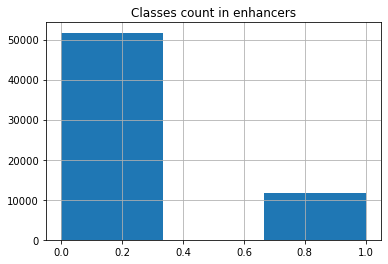

In [60]:
fig, ax = plt.subplots()
(y>min_active_tpm_value_enhancers).astype(int).hist(ax=ax, bins=3)
ax.set_title(f"Classes count in {region}")

In [61]:
# Rate features-samples of data
X.shape[0] / X.shape[1]

416.3486842105263

In [62]:
print("\n".join((
    f"Nan values report for GM12878 promoters data:",
    f"In the document there are {X.isna().values.sum()} NaN values out of {X.values.size} values.",
    f"The sample (row) with most values has {X.isna().sum(axis=1).max()} NaN values out of {X.shape[1]} values.",
    f"The feature (column) with most values has {X.isna().sum().max()} NaN values out of {X.shape[0]} values."
)))

Nan values report for GM12878 promoters data:
In the document there are 62 NaN values out of 9619320 values.
The sample (row) with most values has 4 NaN values out of 152 values.
The feature (column) with most values has 56 NaN values out of 63285 values.


In [63]:
# Knn imputation
X = knn_imputation(X)

In [64]:
# Checking for constant features
drop_constant_features(X).shape != X.shape

False

In [65]:
# Data normalization
X = robust_zscoring(X)

In [66]:
p_value_threshold = 0.00001
correlation_threshold = 0.05

# Pearson test
for feature in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running Pearson test:   0%|          | 0/152 [00:00<?, ?it/s]

The feature H3K9me3 does not correlate in a statistically significant manner with the output.
The feature FOXK2 does not correlate in a statistically significant manner with the output.


In [67]:
# Pearson test
for feature_left in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            # Since the pearson correlation is simmetric, we do not need to check
            # for the entire squared matrix of features but the upper triangular one
            # is sufficient.
            continue
        pearson_result = compute_pearson(
            X,
            feature_left,
            feature_right,
            cell_line=cell_line,
            region=region
            
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.90:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

Running Pearson test:   0%|          | 0/152 [00:00<?, ?it/s]

The feature IKZF1 is highly correlated with IKZF2 (0.9243716384258694).


In [68]:
# Spearman test
for feature in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running Spearman test:   0%|          | 0/152 [00:00<?, ?it/s]

The feature H3K9me3 does not correlate in a statistically significant manner with the output.


In [69]:
# Spearman test
for feature_left in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            # Since the pearson correlation is simmetric, we do not need to check
            # for the entire squared matrix of features but the upper triangular one
            # is sufficient.
            continue
        pearson_result = compute_spearmanr(
            X,
            feature_left,
            feature_right,
            cell_line=cell_line,
            region=region
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.90:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

Running Spearman test:   0%|          | 0/152 [00:00<?, ?it/s]

In [70]:
#INSERIRE NELLA LISTA LE FEATURES non legate all'output TROVATE PRIMA

for feature in tqdm(("H3K9me3", "FOXK2"), desc=f"Running MINE test", dynamic_ncols=True, leave=False):
    mine = MINE()
    mine.compute_score(X[feature].values.ravel(), y.values.ravel())
    score = mine.mic()
    if score < correlation_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running MINE test:   0%|          | 0/2 [00:00<?, ?it/s]

The feature H3K9me3 does not correlate in a statistically significant manner with the output.
The feature FOXK2 does not correlate in a statistically significant manner with the output.


In [66]:
p_value_threshold = 0.01
correlation_threshold = 0.95
scores = []
for i, column in tqdm(
    enumerate(X.columns),
    total=len(X.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
    for feature in X.columns[i+1:]:
        correlation, p_value = pearsonr(X[column].values.ravel(), X[feature].values.ravel())
        correlation = np.abs(correlation)
        scores.append((correlation, column, feature))
scores.sort(reverse=True)

Running Pearson test for enhancers:   0%|          | 0/152 [00:00<?, ?it/s]

Most correlated features from enhancers epigenomes


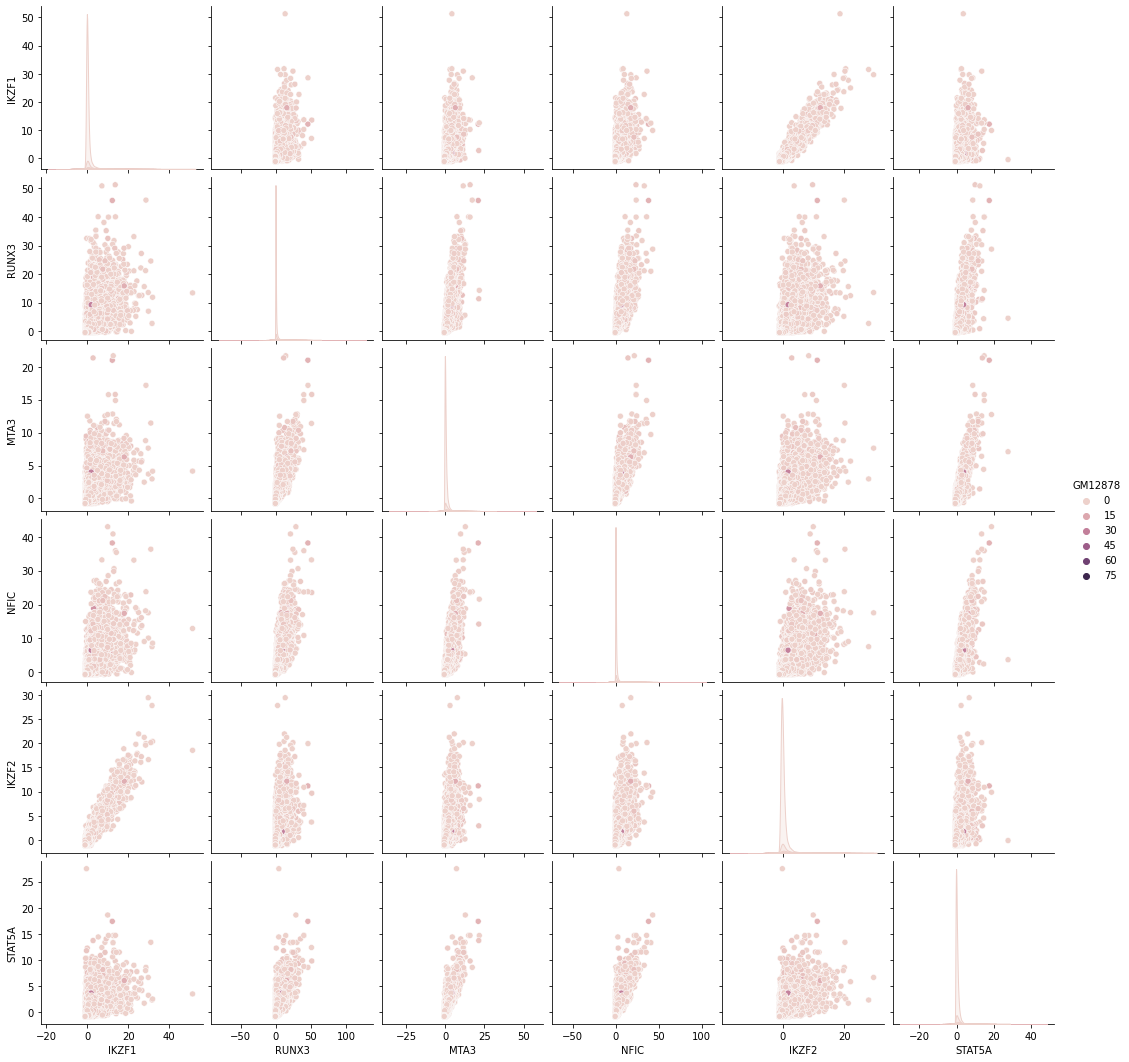

In [67]:
_, firsts, seconds = list(zip(*scores[:3]))
columns = list(set(firsts+seconds))
print(f"Most correlated features from {region} epigenomes")
sns.pairplot(pd.concat([
    X[columns],
    y,
], axis=1), hue=y.columns[0])
plt.show()

Least correlated features from enhancers epigenomes


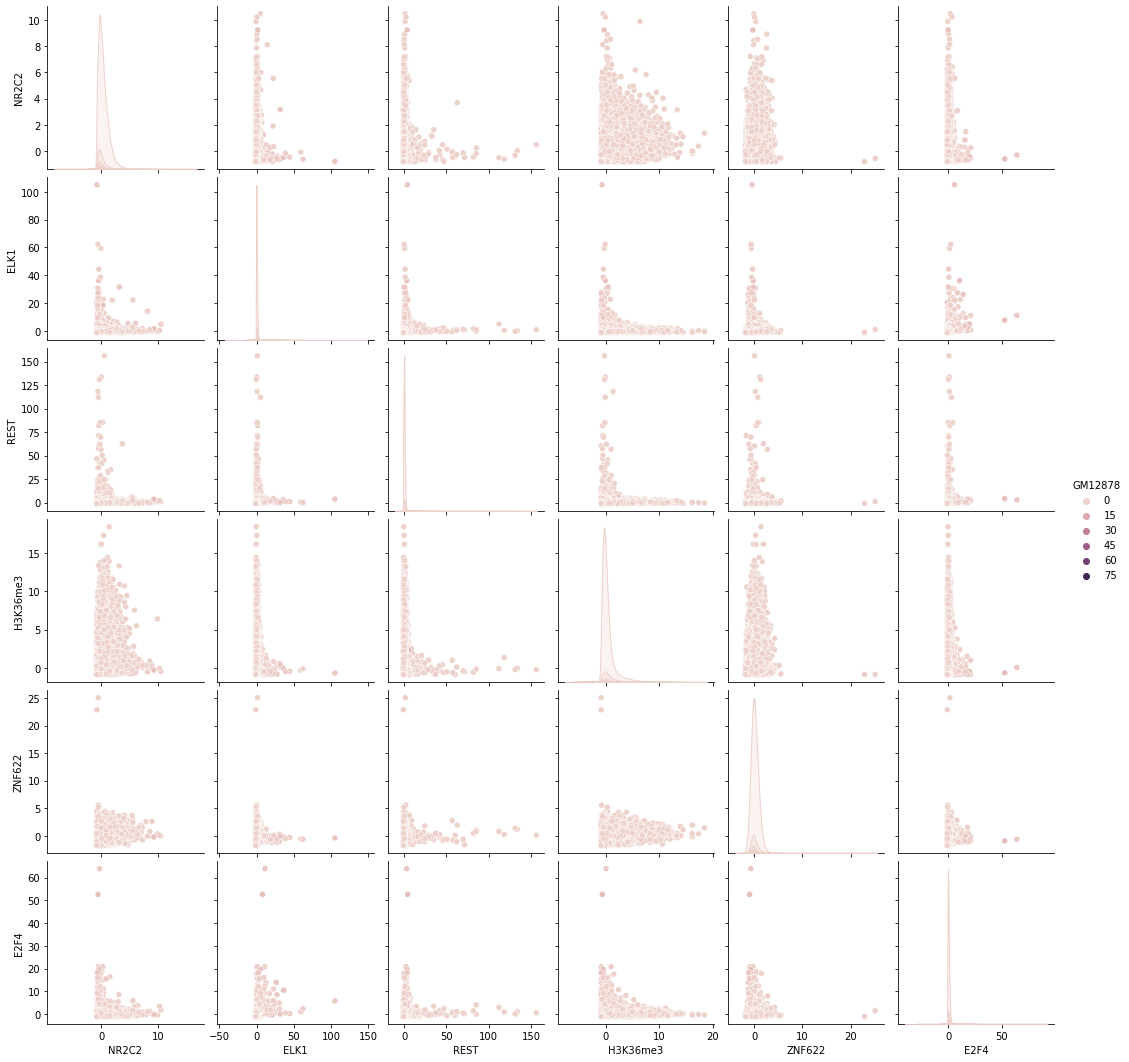

In [68]:
_, firsts, seconds = list(zip(*scores[-3:]))
columns = list(set(firsts+seconds))
print(f"Least correlated features from {region} epigenomes")
sns.pairplot(pd.concat([
    X[columns],
    y,
], axis=1), hue=y.columns[0])
plt.show()

Top 5 different features from enhancers.


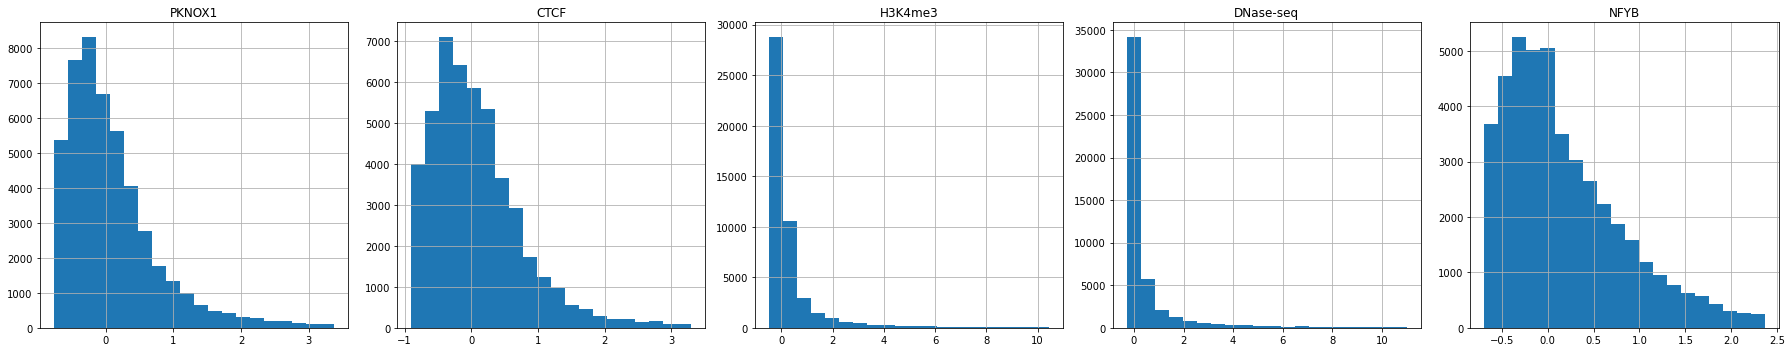

In [69]:
top_number = 5

dist = euclidean_distances(X.T)
most_distance_columns_indices = get_top_most_different(dist, top_number)
columns = X.columns[most_distance_columns_indices]
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
print(f"Top {top_number} different features from {region}.")
for column, axis in zip(columns, axes.flatten()):
    head, tail = X[column].quantile([0.05, 0.95]).values.ravel()

    mask = ((X[column] < tail) & (X[column] > head)).values

    cleared_x = X[column][mask]
    cleared_y = y.values.ravel()[mask]

    cleared_x[cleared_y==0].hist(ax=axis, bins=20)
    cleared_x[cleared_y==1].hist(ax=axis, bins=20)

    axis.set_title(column)
fig.tight_layout()
plt.show()

# Data visualization for Promoters

In [70]:
region = 'promoters'
X, y = active_promoters_vs_inactive_promoters(cell_line)

Text(0.5, 1.0, 'Classes count in promoters')

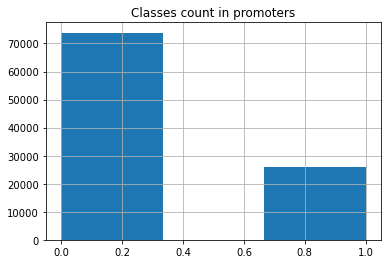

In [71]:
fig, ax = plt.subplots()
(y>1).astype(int).hist(ax=ax, bins=3)
ax.set_title(f"Classes count in {region}")

In [72]:
# Rate features-samples of data
X.shape[0] / X.shape[1]

657.1118421052631

In [73]:
print("\n".join((
    f"Nan values report for GM12878 promoters data:",
    f"In the document there are {X.isna().values.sum()} NaN values out of {X.values.size} values.",
    f"The sample (row) with most values has {X.isna().sum(axis=1).max()} NaN values out of {X.shape[1]} values.",
    f"The feature (column) with most values has {X.isna().sum().max()} NaN values out of {X.shape[0]} values."
)))

Nan values report for GM12878 promoters data:
In the document there are 423 NaN values out of 15181912 values.
The sample (row) with most values has 40 NaN values out of 152 values.
The feature (column) with most values has 198 NaN values out of 99881 values.


In [74]:
# Knn imputation
X = knn_imputation(X)

In [75]:
# Checking for constant features
drop_constant_features(X).shape != X.shape

False

In [76]:
# Data normalization
X = robust_zscoring(X)

In [77]:
p_value_threshold = 0.01
correlation_threshold = 0.05

# Pearson test
for feature in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running Pearson test:   0%|          | 0/152 [00:00<?, ?it/s]

The feature EZH2 does not correlate in a statistically significant manner with the output.
The feature BMI1 does not correlate in a statistically significant manner with the output.
The feature H3K4me2 does not correlate in a statistically significant manner with the output.
The feature YBX1 does not correlate in a statistically significant manner with the output.


In [80]:
# Pearson test
for feature_left in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            # Since the pearson correlation is simmetric, we do not need to check
            # for the entire squared matrix of features but the upper triangular one
            # is sufficient.
            continue
        pearson_result = compute_pearson(
            X,
            feature_left,
            feature_right,
            cell_line=cell_line,
            region=region
            
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.90:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

Running Pearson test:   0%|          | 0/152 [00:00<?, ?it/s]

The feature IKZF1 is highly correlated with IKZF2 (0.9243716384258694).
The feature POLR2A is highly correlated with POLR2AphosphoS5 (0.9295803881390623).


In [81]:
# Spearman test
for feature in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running Spearman test:   0%|          | 0/152 [00:00<?, ?it/s]

In [82]:
# Spearman test
for feature_left in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            # Since the pearson correlation is simmetric, we do not need to check
            # for the entire squared matrix of features but the upper triangular one
            # is sufficient.
            continue
        pearson_result = compute_spearmanr(
            X,
            feature_left,
            feature_right,
            cell_line=cell_line,
            region=region
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.90:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

Running Spearman test:   0%|          | 0/152 [00:00<?, ?it/s]

The feature POLR2A is highly correlated with POLR2AphosphoS5 (0.9184715681962269).


In [83]:
#INSERIRE NELLA LISTA LE FEATURES non legate all'output TROVATE PRIMA, Se sono state trovate!

for feature in tqdm(("EZH2", "BMI1", "H3K4me2", "YBX1"), desc=f"Running MINE test", dynamic_ncols=True, leave=False):
    mine = MINE()
    mine.compute_score(X[feature].values.ravel(), y.values.ravel())
    score = mine.mic()
    if score < correlation_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running MINE test:   0%|          | 0/4 [00:00<?, ?it/s]

The feature EZH2 does not correlate in a statistically significant manner with the output.
The feature BMI1 does not correlate in a statistically significant manner with the output.
The feature YBX1 does not correlate in a statistically significant manner with the output.


In [78]:
correlation_threshold = 0.95
scores = []
for i, column in tqdm(
    enumerate(X.columns),
    total=len(X.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
    for feature in X.columns[i+1:]:
        correlation, p_value = pearsonr(X[column].values.ravel(), X[feature].values.ravel())
        correlation = np.abs(correlation)
        scores.append((correlation, column, feature))
scores.sort(reverse=True)

Running Pearson test for promoters:   0%|          | 0/152 [00:00<?, ?it/s]

Most correlated features from promoters epigenomes


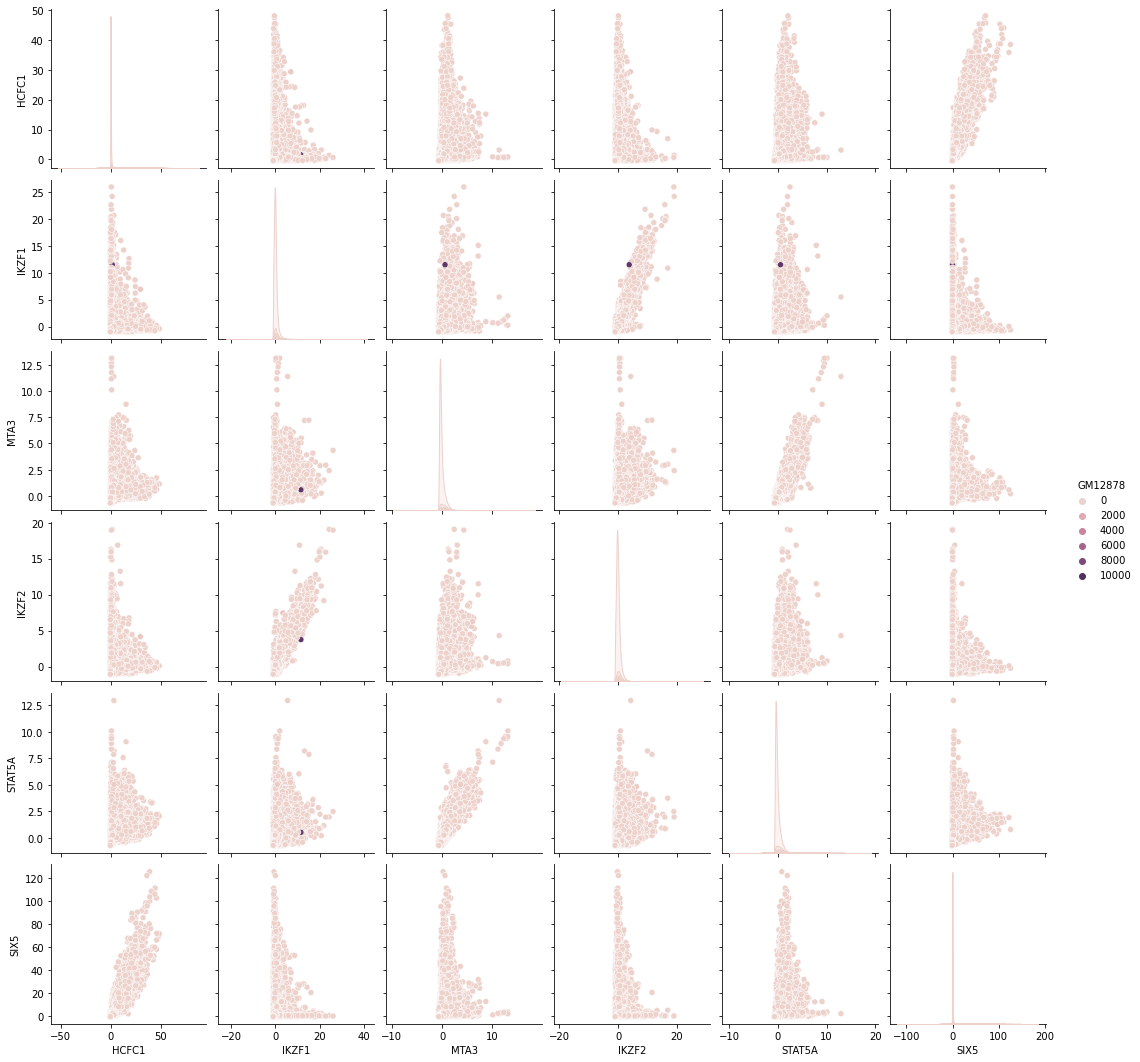

In [79]:
_, firsts, seconds = list(zip(*scores[:3]))
columns = list(set(firsts+seconds))
print(f"Most correlated features from {region} epigenomes")
sns.pairplot(pd.concat([
    X[columns],
    y,
], axis=1), hue=y.columns[0])
plt.show()

Least correlated features from promoters epigenomes


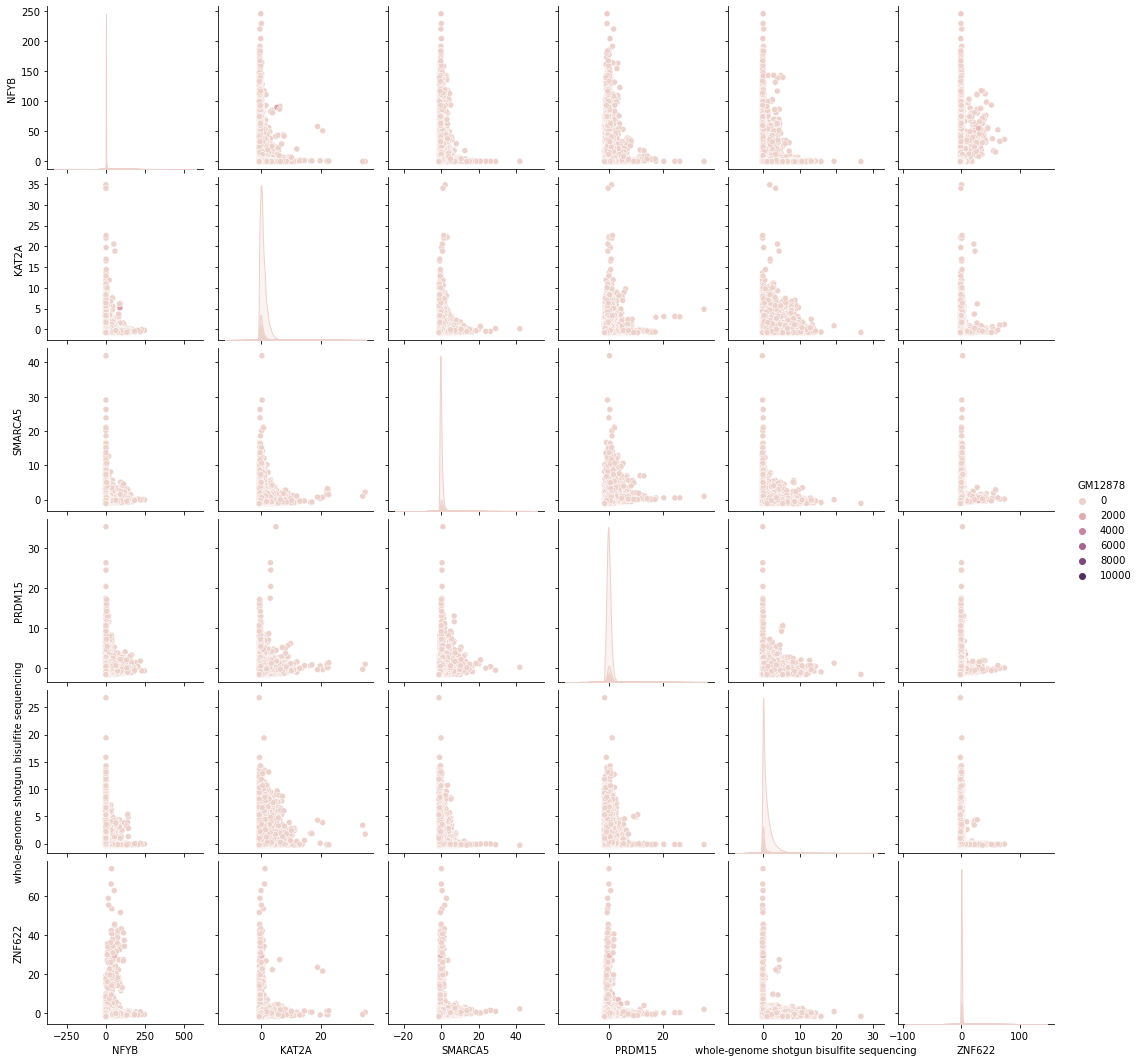

In [80]:
_, firsts, seconds = list(zip(*scores[-3:]))
columns = list(set(firsts+seconds))
print(f"Least correlated features from {region} epigenomes")
sns.pairplot(pd.concat([
    X[columns],
    y,
], axis=1), hue=y.columns[0])
plt.show()

Top 5 different features from promoters.


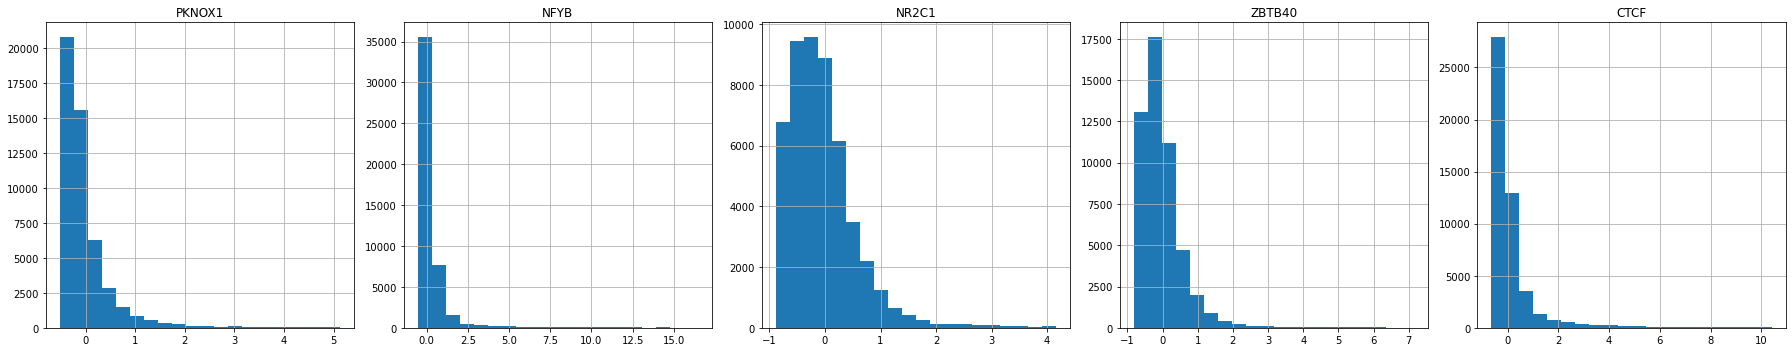

In [81]:
top_number = 5

dist = euclidean_distances(X.T)
most_distance_columns_indices = get_top_most_different(dist, top_number)
columns = X.columns[most_distance_columns_indices]
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
print(f"Top {top_number} different features from {region}.")
for column, axis in zip(columns, axes.flatten()):
    head, tail = X[column].quantile([0.05, 0.95]).values.ravel()

    mask = ((X[column] < tail) & (X[column] > head)).values

    cleared_x = X[column][mask]
    cleared_y = y.values.ravel()[mask]

    cleared_x[cleared_y==0].hist(ax=axis, bins=20)
    cleared_x[cleared_y==1].hist(ax=axis, bins=20)

    axis.set_title(column)
fig.tight_layout()
plt.show()